# <i class="fa-solid fa-circle-plus"></i> Generalized Additive Models

Generalized Additive Models (GAMs) offer a powerful and flexible extension to traditional linear models by allowing for **non-linear, additive relationships** between each predictor and the outcome. Unlike standard linear regression, which assumes a strictly linear association between predictors and the response variable, GAMs replace each linear term with a smooth function, enabling the model to better capture complex patterns in the data. Thanks to their additive structure, each predictor contributes independently to the model, making it easy to interpret the effect of each variable. 

So instead of using the standard linear function

$$ y = b_0 + b_1 x_1 + b_2 x_2 + ... + b_i x_i + \epsilon $$

we have something like this:

$$ y = b_0 + f_1(x_1) + f_2(x_2) + ... + f_i(x_i) + \epsilon $$


In short, instead of using fixed slope coefficients $b_i$​ that assume a straight-line relationship, we replace them with flexible (possibly non-linear) smooth functions $f_i$​ for each predictor. These functions can be anything from constant functions and polynomials to wavelets.

So in comparison to simple splines regression which ([last semester](https://mibur1.github.io/psy111/book/statistics/9_Spline_Reg/0_Introduction.html)) was introduced to predict $y$ on the basis of a single predictor $x$, GAMs are a generalization which allows us to predict $y$ given multiple predictors $x_1 ... x_p$.

In [1]:
from jupyterquiz import display_quiz
display_quiz("quiz/GAM.json", shuffle_answers=False)

<IPython.core.display.Javascript object>

## Today's data: The Diabetes dataset

For today's practical demonstration, we will work with the `Diabetes` dataset from `scikit-learn`. This dataset contains medical information collected from 442 diabetes patients, including:

- Features: 10 baseline measures from the beginning of the study: age, sex, Body Mass Index (BMI), average blood pressure, as well as six blood serum measurements (e.g. cholesterol, blood sugar, etc.)
- Target: A quantitative measure of disease progression one year after the baseline measurements were taken.

You can find more information [here](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html).

In [2]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

# Get data
diabetes = datasets.load_diabetes(as_frame=True)
X = diabetes.data
y = diabetes.target

# Split the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

To explore the relationships between each feature and the target, we plot each predictor against the disease progression outcome. These scatter plots with simple linear regressions help us to visually assess whether the relationship between a feature and the target is linear or if we need a more flexible model approach:

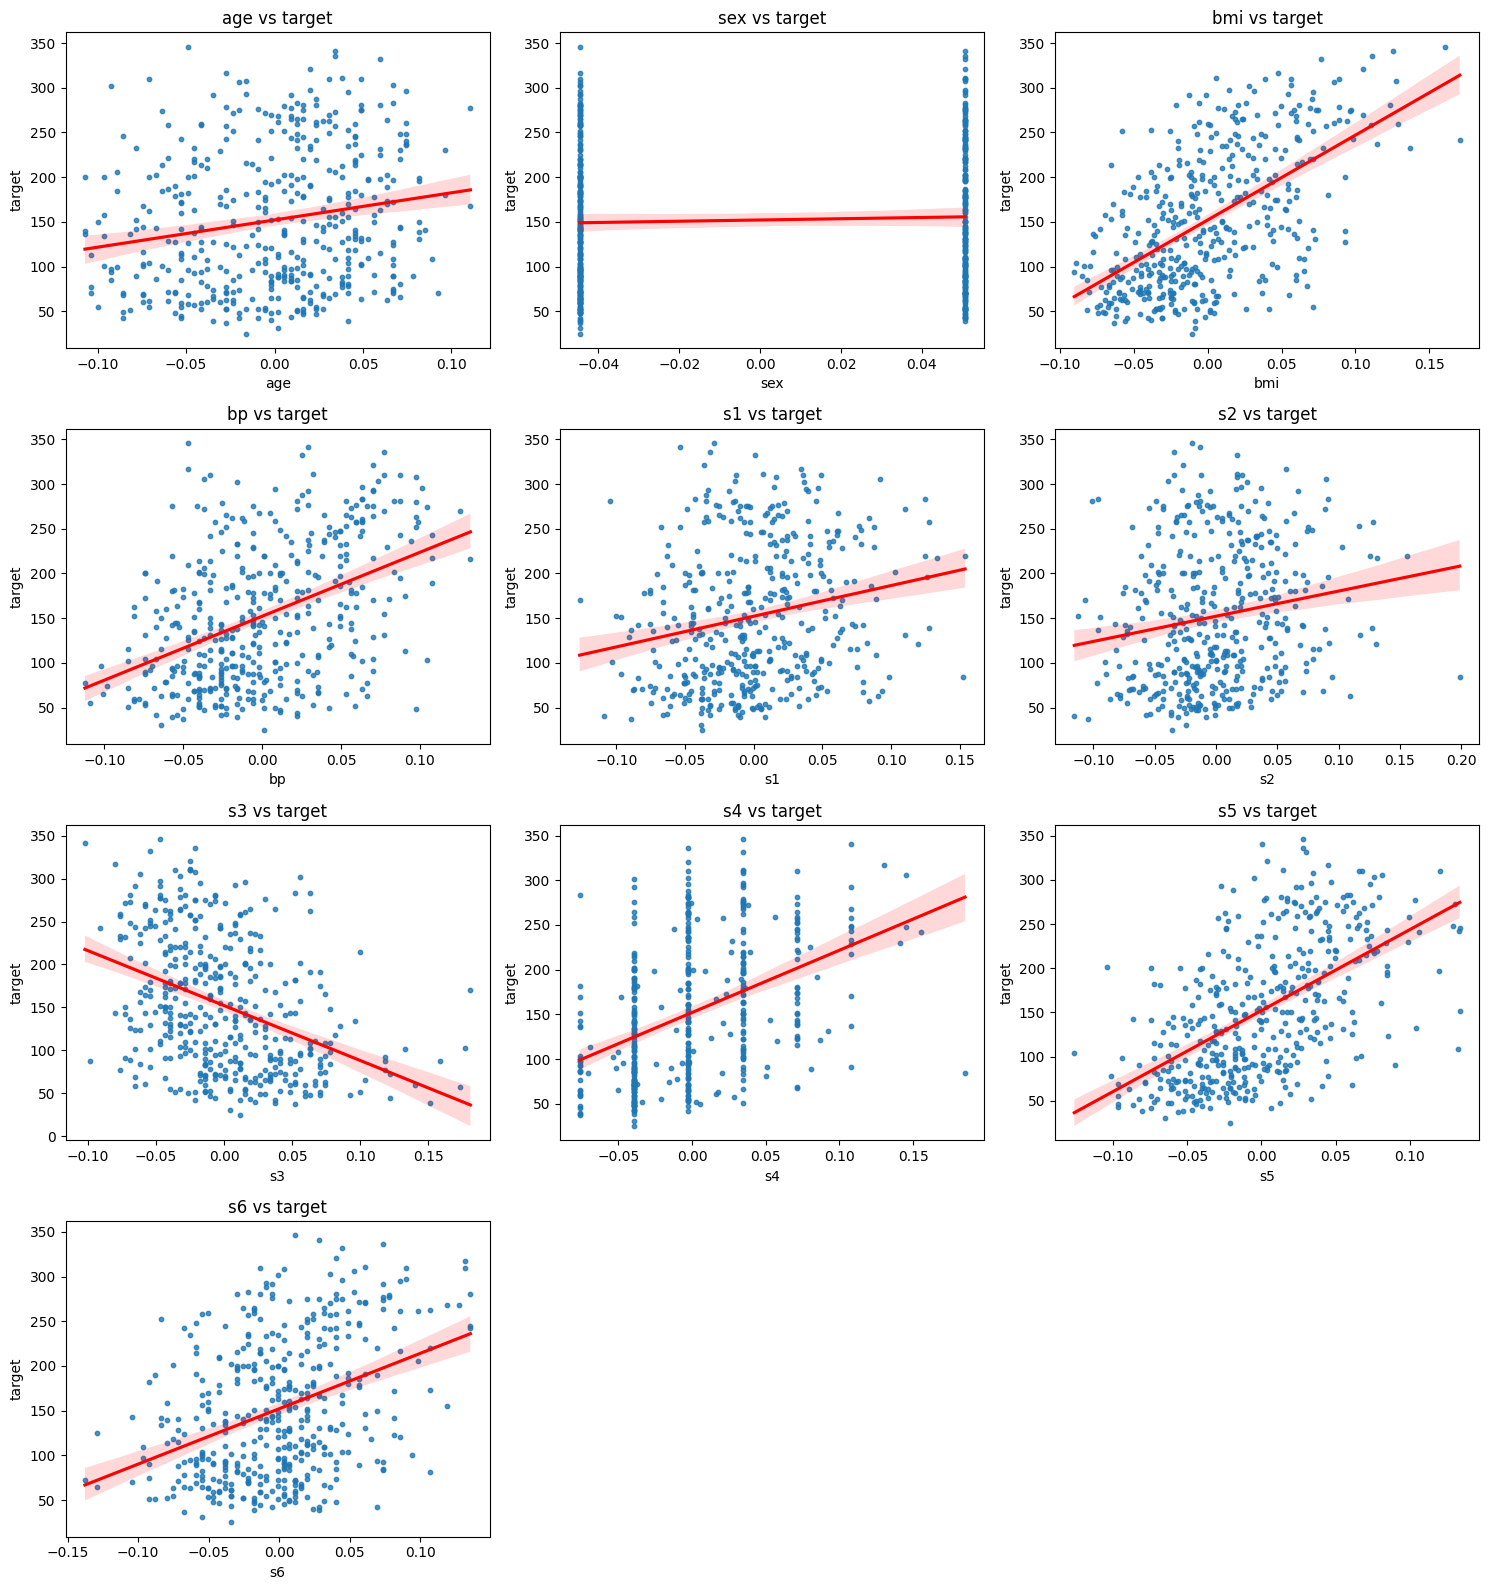

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets

# Load data
diabetes = datasets.load_diabetes(as_frame=True)
X = diabetes.data
y = diabetes.target

# Combine into a single DataFrame for easy plotting
df = X.copy()
df['target'] = y

features_to_plot = X.columns

# Set up the plot grid
num_features = len(features_to_plot)
cols = 3
rows = (num_features + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(15, 4 * rows))
axes = axes.flatten()

# Plot each feature (except 'sex') against the target
for i, col in enumerate(features_to_plot):
    sns.regplot(x=col, y='target', data=df, ax=axes[i], scatter_kws={'s': 10}, line_kws={'color': 'red'})
    axes[i].set_title(f"{col} vs target")

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Although the linear regression fits seem to be reasonable, we might suspect that a more flexible approach could be beneficial, so let's try it!


## GAMs in Python

There are multiple options for implementing GAMs. We will here use `statsmodels`, as you should already be familiar with it from the previouis semester. The workflow is the following:

1. Separate smooth (continuous) and categorical features
2. Create spline basis functions for the continuous features using B-splines
3. Fit the GAM with both the smooth and categorical predictors

In [4]:
from statsmodels.gam.api import GLMGam, BSplines

spline_features = ['age', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']
categorical_features = ['sex']

# Create smoother for continuous variables
bs = BSplines(X_train[spline_features], df=[6]*len(spline_features), degree=[3]*len(spline_features))

# Fit GAM with smoother and exog for categorical
gam = GLMGam(y_train, exog=X_train[categorical_features], smoother=bs)
res = gam.fit()

print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 target   No. Observations:                  309
Model:                         GLMGam   Df Residuals:                   263.00
Model Family:                Gaussian   Df Model:                        45.00
Link Function:               Identity   Scale:                          2998.6
Method:                         PIRLS   Log-Likelihood:                -1650.5
Date:                Thu, 18 Dec 2025   Deviance:                   7.8864e+05
Time:                        16:48:39   Pearson chi2:                 7.89e+05
No. Iterations:                     3   Pseudo R-squ. (CS):             0.7023
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sex         -289.6664     78.808     -3.676      0.0

```{margin}
Remember: B-splines are a series of piecewise polynomial functions that are joined smoothly at certain points called knots.
```

For the B-splines<sup>{{splines}}</sup> we choose:

- `df=[6]*len(spline_features)` -> 6 basis functions per feature
- `degree=[3]*len(spline_features)` -> cubic splines (degree 3)

The output includes parameter estimates for all spline basis functions and categorical variables:

- The `coef` column shows the estimated effect.
- The `P>|z|` column tells you whether the estimate is statistically significant
- The Pseudo `R-squared (CS)` gives a rough measure of model fit (here around 0.70)

Due to the additive nature of GAMs, we can isolate and visualise the effect of each smooth term individually. This helps us understand the relationship between each predictor and the response, controlling for all other variables:

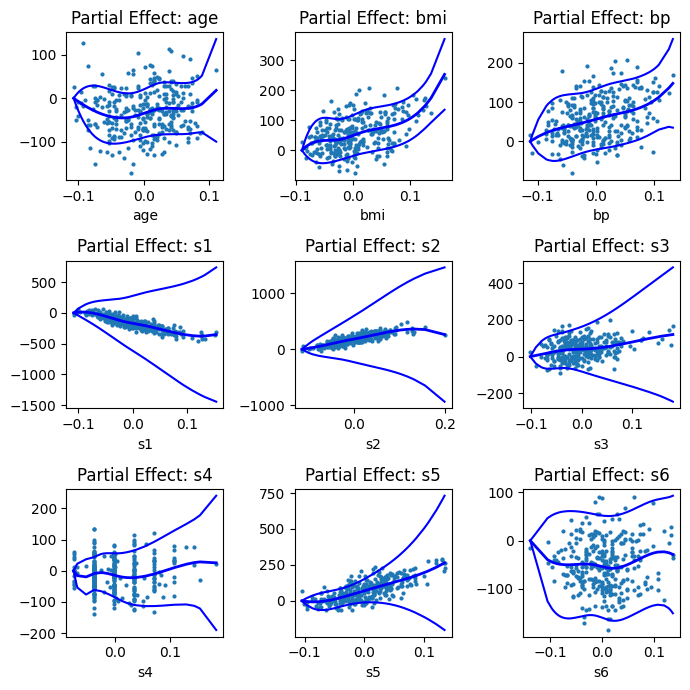

In [5]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(3,3, figsize=(7,7))

for i, feature in enumerate(spline_features):
    res.plot_partial(i, cpr=True, ax=ax[i//3, i%3])
    ax[i//3, i%3].set_title(f"Partial Effect: {feature}")

plt.tight_layout()

Each subplot shows how the modelled relationship between a feature and the target behaves nonlinearly. The `cpr=True` option adds confidence intervals around the estimated smooth curve.

```{admonition} Summary
:class: tip

- GAMs allow flexible, interpretable models where you don’t assume linearity for every predictor.
- `statsmodels` makes it easy to combine smooth terms (B-splines or alternatively Cyclic Cubic Splines) with categorical or linear predictors.
- You can inspect smooth effects with `.plot_partial()`, and linear terms directly from the model summary.
```